<a href="https://colab.research.google.com/github/mehrotrasan16/Keras-Deep-Learning/blob/05-RNN-LSTM-Seq2Seq-Networks/univariate_time_series_multi_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
from numpy import load
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Load Dataset

In [5]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [7]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

## Forecasting Several Steps Ahead

If we want to predict the next 10 values, instead of just 1, we can modify our previous model to predict the next 10 values. We first need to load the dataset that has sequences with 9 more time steps.

In [8]:
n_steps = 50
series = load('/content/drive/MyDrive/Colab Notebooks/CS581-TestResults/assignment5/HW5-supp-files/univariate-time-series-multi-step.npy')

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [9]:
#Improve upon this model with your own model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1389 - val_loss: 0.0753
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0551
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0470
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0422
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0396
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0376
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0360
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0350
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0342
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0336

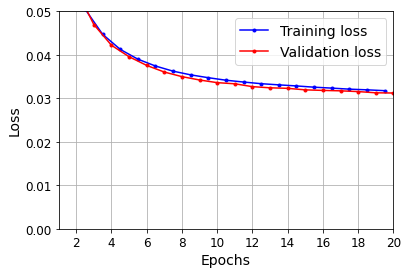

In [10]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Now let's predict the next 10 values:

In [11]:
series = load('/content/drive/MyDrive/Colab Notebooks/CS581-TestResults/assignment5/HW5-supp-files/univariate-time-series-multi-step-test.npy')
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

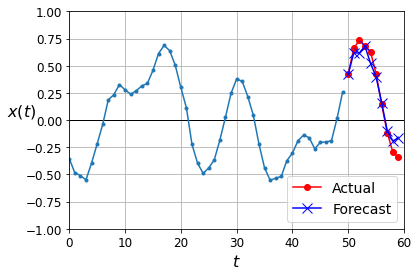

In [12]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [13]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0325


0.032544732093811035

## RNN Model

In [14]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape,X_new.shape,Y_new.shape

((7000, 50, 1), (1000, 50, 1), (7000, 10), (1000, 10), (1, 50, 1), (1, 10, 1))

In [15]:
rnnmodel = keras.models.Sequential([
    keras.layers.LSTM(256,input_shape=[50,1]),
    keras.layers.Dense(100),
    keras.layers.Dense(10)
])
rnnmodel.compile(loss="mse", optimizer="adam")
print(rnnmodel.summary())
rnnhistory = rnnmodel.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=20, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 290,902
Trainable params: 290,902
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
55/55 [==============================] - 1s 18ms/step - loss: 0.0810 - val_loss: 0.0573
Epoch 2/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0501 - val_loss: 0.0440
Epoch 3/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0400 - val_loss: 0.0361
Epoch 4/20
55/55 [==============================] - 0s 9ms/step - loss: 0.0354

In [17]:
Y1 = rnnmodel(X_valid)

In [18]:
Y1.shape

TensorShape([2000, 10])

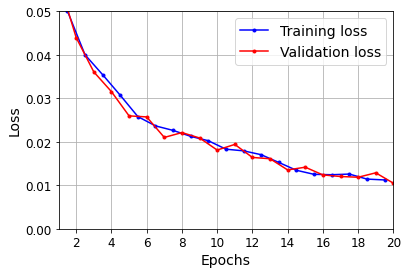

In [21]:
plot_learning_curves(rnnhistory.history["loss"], rnnhistory.history["val_loss"])
plt.show()

In [19]:
series = load('/content/drive/MyDrive/Colab Notebooks/CS581-TestResults/assignment5/HW5-supp-files/univariate-time-series-multi-step-test.npy')
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = rnnmodel.predict(X_new)[..., np.newaxis]

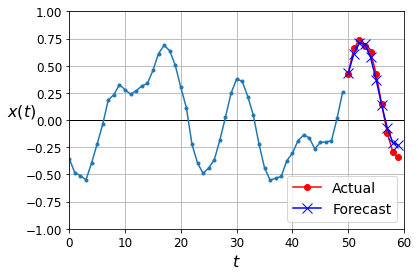

In [20]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [16]:
scores = rnnmodel.evaluate(X_test,Y_test)
print(f"RMSE: {scores}")

32/32 [==============================] - 0s 3ms/step - loss: 0.0112
RMSE: 0.011172199621796608
